# Site: https://ranked.vote/us/vt/btv/2009/03/mayor/
# 2019 RCV Python library: https://pypi.org/project/pyrankvote/
# repo here: https://github.com/jontingvold/pyrankvote

In [1]:
import pandas as pd
import numpy as np
import pyrankvote
from pyrankvote import Candidate, Ballot
from IPython.display import Image


### 1. Load data

#### a. Ballots

In [2]:
data = "../data/us_vt_btv_2009_03_mayor.normalized.csv"
df = pd.read_csv(data)
df.head()

ballot_id  rank         choice
0  000001-00-0001     1       Bob Kiss
1  000001-00-0001     2  Andy Montroll
2  000001-00-0006     1       Bob Kiss
3  000001-00-0006     2  Andy Montroll
4  000001-00-0008     1       Bob Kiss

In [3]:
df.shape

(28703, 3)

In [4]:
df.choice.unique()

array(['Bob Kiss', 'Andy Montroll', 'Dan Smith', 'Kurt Wright',
       'James Simpson', 'Write-in', '$OVERVOTE', '$UNDERVOTE'],
      dtype=object)

#### b. Candidates

In [5]:
kiss = Candidate('Bob Kiss')
montroll = Candidate('Andy Montroll')
wright = Candidate('Kurt Wright')
smith = Candidate('Dan Smith')
simpson = Candidate('James Simpson')

candidates = [kiss, montroll, wright, smith, simpson]


## Getting rid of duplicates

In [6]:
len(df.drop_duplicates())

28703

In [7]:
len(df)

28703

In [8]:
df['ballot_id_rank'] = df['ballot_id'].astype(str) + '_' + df['rank'].astype(str)

In [9]:
df.head()

ballot_id  rank         choice    ballot_id_rank
0  000001-00-0001     1       Bob Kiss  000001-00-0001_1
1  000001-00-0001     2  Andy Montroll  000001-00-0001_2
2  000001-00-0006     1       Bob Kiss  000001-00-0006_1
3  000001-00-0006     2  Andy Montroll  000001-00-0006_2
4  000001-00-0008     1       Bob Kiss  000001-00-0008_1

In [10]:
df[df.duplicated(subset='ballot_id_rank') == True]

Empty DataFrame
Columns: [ballot_id, rank, choice, ballot_id_rank]
Index: []

In [11]:
df[df['ballot_id'] == 810723]  # definite duplicates

Empty DataFrame
Columns: [ballot_id, rank, choice, ballot_id_rank]
Index: []

In [12]:
len(df.drop_duplicates(subset='ballot_id_rank'))

123306

In [13]:
df = df.drop_duplicates(subset='ballot_id_rank')

### 2. Preprocess data

#### Pivot data

In [12]:
df1 = df.pivot(index='ballot_id', columns='rank', values='choice').rename_axis(None, axis=1).reset_index()
df1.head()

ballot_id              1              2            3    4    5
0  000001-00-0001       Bob Kiss  Andy Montroll          NaN  NaN  NaN
1  000001-00-0002  Andy Montroll            NaN          NaN  NaN  NaN
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  NaN  NaN
3  000001-00-0004  Andy Montroll    Kurt Wright          NaN  NaN  NaN
4  000001-00-0005    Kurt Wright            NaN          NaN  NaN  NaN

#### Remove NaN

In [13]:
df1 = df1.replace(np.nan, '0')
df1.head()

ballot_id              1              2            3  4  5
0  000001-00-0001       Bob Kiss  Andy Montroll            0  0  0
1  000001-00-0002  Andy Montroll              0            0  0  0
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  0  0
3  000001-00-0004  Andy Montroll    Kurt Wright            0  0  0
4  000001-00-0005    Kurt Wright              0            0  0  0

In [14]:
list_of_ballot_choices = df1[[1, 2, 3, 4, 5]].values.tolist()

In [15]:
for x in list_of_ballot_choices:
    while '0' in x:
        x.remove('0')

In [16]:
df1['ballot_choices_list'] = list_of_ballot_choices
df1.head()

ballot_id              1              2            3  4  5  \
0  000001-00-0001       Bob Kiss  Andy Montroll            0  0  0   
1  000001-00-0002  Andy Montroll              0            0  0  0   
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  0  0   
3  000001-00-0004  Andy Montroll    Kurt Wright            0  0  0   
4  000001-00-0005    Kurt Wright              0            0  0  0   

                      ballot_choices_list  
0               [Bob Kiss, Andy Montroll]  
1                         [Andy Montroll]  
2  [Andy Montroll, Bob Kiss, Kurt Wright]  
3            [Andy Montroll, Kurt Wright]  
4                           [Kurt Wright]

#### Remove invalid data

Special exceptions, from https://github.com/ranked-vote/rcv-data-format/blob/master/README.md#normalized-vs-raw:

- UNDERVOTE: the ballot did not list a candidate for this rank.
- OVERVOTE: the ballot voted for multiple candidates in the rank, invalidating the vote for that rank (and possibly others, depending on the jurisdiction’s rules.)
- WRITE_IN: the ballot listed a write-in candidate, and the raw voting data does not indicate that candidate’s name.

In [17]:
def remove_anomalies_from_ballots(ballots, value_to_remove):
    """
    ballots: series from dataframe. Each row contains a list of ranked candidates representing 1 ballot.
    value_to_remove: string that a ballot contains as a condition for its deletion
    """
    indices_to_drop = []
    
    for index, value in enumerate(ballots):
        if value_to_remove in value:
            indices_to_drop.append(index)
                   
    return indices_to_drop


In [18]:
# Removing write-ins, undervotes, and overvotes

write_in_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], 'Write-in')
undervote_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], '$UNDERVOTE')
overvote_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], '$OVERVOTE')

indices_to_drop = write_in_indices_to_drop +  undervote_indices_to_drop + overvote_indices_to_drop

In [19]:
df1 = df1.drop(index=indices_to_drop)
df1.shape

(8735, 7)

In [ ]:
# Interesting note. Dataset originally had ~124k rows of data. After dropping invalid ballots + write-ins,
# undervotes, and overvotes, it gets reduced to ~13k. Very big loss of data.

In [20]:
candidates_array = []

for candidate_list in df1['ballot_choices_list']:
    ballot = []
    for candidate in candidate_list:
        candidate = candidate.strip(' ')
        ballot.append(Candidate(candidate))
    candidates_array.append(ballot)
candidates_array

[[<Candidate('Bob Kiss')>, <Candidate('Andy Montroll')>],
 [<Candidate('Andy Montroll')>],
 [<Candidate('Andy Montroll')>,
  <Candidate('Bob Kiss')>,
  <Candidate('Kurt Wright')>],
 [<Candidate('Andy Montroll')>, <Candidate('Kurt Wright')>],
 [<Candidate('Kurt Wright')>],
 [<Candidate('Bob Kiss')>, <Candidate('Andy Montroll')>],
 [<Candidate('Kurt Wright')>],
 [<Candidate('Bob Kiss')>,
  <Candidate('Dan Smith')>,
  <Candidate('Andy Montroll')>,
  <Candidate('Kurt Wright')>,
  <Candidate('James Simpson')>],
 [<Candidate('Bob Kiss')>,
  <Candidate('James Simpson')>,
  <Candidate('Andy Montroll')>],
 [<Candidate('Kurt Wright')>],
 [<Candidate('Dan Smith')>, <Candidate('Bob Kiss')>],
 [<Candidate('Kurt Wright')>],
 [<Candidate('Bob Kiss')>, <Candidate('Dan Smith')>],
 [<Candidate('Bob Kiss')>,
  <Candidate('Andy Montroll')>,
  <Candidate('Dan Smith')>,
  <Candidate('Kurt Wright')>,
  <Candidate('James Simpson')>],
 [<Candidate('Bob Kiss')>, <Candidate('Andy Montroll')>],
 [<Candidate('Bob 

In [21]:
df1['ballot_choices_list_with_candidate_objects'] = candidates_array
df1.head()

ballot_id              1              2            3  4  5  \
0  000001-00-0001       Bob Kiss  Andy Montroll            0  0  0   
1  000001-00-0002  Andy Montroll              0            0  0  0   
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  0  0   
3  000001-00-0004  Andy Montroll    Kurt Wright            0  0  0   
4  000001-00-0005    Kurt Wright              0            0  0  0   

                      ballot_choices_list  \
0               [Bob Kiss, Andy Montroll]   
1                         [Andy Montroll]   
2  [Andy Montroll, Bob Kiss, Kurt Wright]   
3            [Andy Montroll, Kurt Wright]   
4                           [Kurt Wright]   

  ballot_choices_list_with_candidate_objects  
0                  [Bob Kiss, Andy Montroll]  
1                            [Andy Montroll]  
2     [Andy Montroll, Bob Kiss, Kurt Wright]  
3               [Andy Montroll, Kurt Wright]  
4                              [Kurt Wright]

## **Uncomment and use this section to remove a candidate from all ballots in df2

In [ ]:
#import copy
#candidates_array_copy = copy.deepcopy(candidates_array) 
#candidates_array_copy

In [ ]:
#df2 = df1.copy(deep=True)
#df2['ballot_choices_list_with_candidate_objects'] = candidates_array_copy

In [ ]:
#df1['ballot_choices_list_with_candidate_objects']

In [ ]:
#def rm_cand_from_ballot(cand_rm, df2):
#    for index,value in enumerate(df2['ballot_choices_list_with_candidate_objects']):
#        val = value
#        print(index, value)
#        if cand_rm in val:
#            val.remove(cand_rm)
#            print(index, value)
#

In [ ]:
#rm_cand_from_ballot(Candidate('Bob Kiss'),df2)

In [ ]:
#df2['ballot_choices_list_with_candidate_objects']

In [ ]:
#Only 'ballot_choices_list_with_candidate_objects' column is modified to remove candidates. So use that in further calculations
#df1=df2 

### 3. Create ballot objects

In [22]:
ballot_objects = []

for index,value in enumerate(df1['ballot_choices_list_with_candidate_objects']):
    ballot = Ballot(ranked_candidates=value)
    ballot_objects.append(ballot)
    
ballot_objects

[<Ballot(Bob Kiss, Andy Montroll)>,
 <Ballot(Andy Montroll)>,
 <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>,
 <Ballot(Andy Montroll, Kurt Wright)>,
 <Ballot(Kurt Wright)>,
 <Ballot(Bob Kiss, Andy Montroll)>,
 <Ballot(Kurt Wright)>,
 <Ballot(Bob Kiss, Dan Smith, Andy Montroll, Kurt Wright, James Simpson)>,
 <Ballot(Bob Kiss, James Simpson, Andy Montroll)>,
 <Ballot(Kurt Wright)>,
 <Ballot(Dan Smith, Bob Kiss)>,
 <Ballot(Kurt Wright)>,
 <Ballot(Bob Kiss, Dan Smith)>,
 <Ballot(Bob Kiss, Andy Montroll, Dan Smith, Kurt Wright, James Simpson)>,
 <Ballot(Bob Kiss, Andy Montroll)>,
 <Ballot(Bob Kiss, Andy Montroll, Kurt Wright, Dan Smith, James Simpson)>,
 <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>,
 <Ballot(Dan Smith, Andy Montroll, Kurt Wright, Bob Kiss)>,
 <Ballot(Bob Kiss, Andy Montroll)>,
 <Ballot(Bob Kiss, Andy Montroll)>,
 <Ballot(Bob Kiss, Andy Montroll, Dan Smith)>,
 <Ballot(Bob Kiss, Andy Montroll, Dan Smith, Kurt Wright, James Simpson)>,
 <Ballot(Bob Kiss, Kurt Wright, Dan Smi

In [23]:
df1['ballot_objects'] = ballot_objects
df1.head()

ballot_id              1              2            3  4  5  \
0  000001-00-0001       Bob Kiss  Andy Montroll            0  0  0   
1  000001-00-0002  Andy Montroll              0            0  0  0   
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  0  0   
3  000001-00-0004  Andy Montroll    Kurt Wright            0  0  0   
4  000001-00-0005    Kurt Wright              0            0  0  0   

                      ballot_choices_list  \
0               [Bob Kiss, Andy Montroll]   
1                         [Andy Montroll]   
2  [Andy Montroll, Bob Kiss, Kurt Wright]   
3            [Andy Montroll, Kurt Wright]   
4                           [Kurt Wright]   

  ballot_choices_list_with_candidate_objects  \
0                  [Bob Kiss, Andy Montroll]   
1                            [Andy Montroll]   
2     [Andy Montroll, Bob Kiss, Kurt Wright]   
3               [Andy Montroll, Kurt Wright]   
4                              [Kurt Wright]   

                                   ballot_objects  
0               <Ballot(Bob Kiss, Andy Montroll)>  
1                         <Ballot(Andy Montroll)>  
2  <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>  
3            <Ballot(Andy Montroll, Kurt Wright)>  
4                           <Ballot(Kurt Wright)>

# Audrey testing generate_condorcet_winner.py functions:

In [52]:
# df1

results = pyrankvote.instant_runoff_voting(candidates, df1['ballot_objects'])

In [53]:
results.get_winners()[0].name

'Bob Kiss'

In [55]:
df['pyrankvote_winner'] = results.get_winners()[0].name

In [56]:
def create_ballot_dict(ballots):
    """
    """
    all_ballots = ballots
    ballot_dict = {}
    for i in range(len(all_ballots)):
        ballot_str = str(all_ballots[i])
        curr_ballot = all_ballots[i]
        if ballot_str in ballot_dict:
            ballot_dict[ballot_str][0] = ballot_dict[ballot_str][0] + 1
        else:
            ballot_dict[ballot_str] = [1, all_ballots[i]]
    return ballot_dict


def create_candidate_matrix(candidates):
    candidate_names = []
    for cand in candidates:
        candidate_names.append(cand.name)

    cand_matrix = pd.DataFrame(0, columns=candidate_names, index=candidate_names)
    return cand_matrix


def symbolize_cand_matrix(cand_matrix):
    for i in cand_matrix.index:
        for j in cand_matrix.columns:
            if i == j:
                cand_matrix.loc[i, j] = '`'
            else:
                if cand_matrix.loc[i, j] != '++' and cand_matrix.loc[i, j] != '--':
                    if cand_matrix.loc[i, j] > cand_matrix.loc[j, i]:
                        cand_matrix.loc[i, j] = '++'
                        cand_matrix.loc[j, i] = '--'
                    else:
                        cand_matrix.loc[i, j] = '--'
                        cand_matrix.loc[j, i] = '++'
    return cand_matrix


def countX(lst, x):
    return lst.count(x)


def return_winners(cand_matrix):
    results = []
    result_dict = {}
    for i in cand_matrix.index:
        key = ''.join([str(countX(list(cand_matrix.loc[i]), '--') + 1), ". ", i])
        result_dict[key] = [countX(list(cand_matrix.loc[i]), '--') + 1,
                            (countX(list(cand_matrix.loc[i]), '++'), countX(list(cand_matrix.loc[i]), '--'))]
    for key, item in sorted(result_dict.items(), key=lambda x: x[1]):
        results.append("Rank %s: [Rank, (Wins, losses] %s" % (key, item))

    return results


def condorcet_compile(candidates, ballots):
    ballot_dict = create_ballot_dict(ballots)

    candidate_names = []
    for cand in candidates:
        candidate_names.append(cand.name)

    cand_matrix = pd.DataFrame(0, columns=candidate_names, index=candidate_names)

    for votes, ballot in ballot_dict.values():
        ranked_candidates = [cand.name for cand in list(ballot.ranked_candidates)]
        process_cands = list(cand_matrix.columns)
        for i, current_cand in enumerate(ranked_candidates):
            process_cands.remove(current_cand)
            cand_matrix.loc[current_cand][process_cands] = cand_matrix.loc[current_cand][process_cands] + votes

    symbolize_cand_matrix(cand_matrix)
    return return_winners(cand_matrix)


def parse_condorcet_results(condorcet_results):  # list
    parsed_results = []

    for i in condorcet_results:
        cand = i.split(':')[0].split('. ')[1]
        wins = int(i.split(':')[1].split(', ')[-2:][0].split('(')[1])
        parsed_results.append((cand, wins))

    return parsed_results


def return_condorcet_winner(parsed_results):
    return sorted(parsed_results, key=lambda x: x[1], reverse=True)[0][0]

def main():
    # candidates = list of Candidate() objects
    # ballots = list of Ballot() objects
    df = df1
    cand_list = candidates
    ballots = ballot_objects
    condorcet_results = condorcet_compile(cand_list, ballots)
    parsed_condorcet_results = parse_condorcet_results(condorcet_results)
    winner = return_condorcet_winner(parsed_condorcet_results)

    df['condorcet_winner'] = winner

    if df['pyrankvote_winner'].all() != df['condorcet_winner'].all():
        df['spoiled'] = 'Y'
    else:
        df['spoiled'] = 'N'
    return df
    

In [57]:
main()

ballot_id              1              2              3  \
0     000001-00-0001       Bob Kiss  Andy Montroll              0   
1     000001-00-0002  Andy Montroll              0              0   
2     000001-00-0003  Andy Montroll       Bob Kiss    Kurt Wright   
3     000001-00-0004  Andy Montroll    Kurt Wright              0   
4     000001-00-0005    Kurt Wright              0              0   
...              ...            ...            ...            ...   
8974  000007-00-1710       Bob Kiss              0              0   
8976  000007-00-1712    Kurt Wright      Dan Smith              0   
8977  000007-00-1713    Kurt Wright  Andy Montroll      Dan Smith   
8978  000007-00-1714    Kurt Wright  Andy Montroll              0   
8979  000007-00-1715       Bob Kiss  Andy Montroll  James Simpson   

                  4          5  \
0                 0          0   
1                 0          0   
2                 0          0   
3                 0          0   
4                 0          0   
...             ...        ...   
8974              0          0   
8976              0          0   
8977  James Simpson   Bob Kiss   
8978              0          0   
8979    Kurt Wright  Dan Smith   

                                    ballot_choices_list  \
0                             [Bob Kiss, Andy Montroll]   
1                                       [Andy Montroll]   
2                [Andy Montroll, Bob Kiss, Kurt Wright]   
3                          [Andy Montroll, Kurt Wright]   
4                                         [Kurt Wright]   
...                                                 ...   
8974                                         [Bob Kiss]   
8976                           [Kurt Wright, Dan Smith]   
8977  [Kurt Wright, Andy Montroll, Dan Smith, James ...   
8978                       [Kurt Wright, Andy Montroll]   
8979  [Bob Kiss, Andy Montroll, James Simpson, Kurt ...   

             ballot_choices_list_with_candidate_objects  \
0                             [Bob Kiss, Andy Montroll]   
1                                       [Andy Montroll]   
2                [Andy Montroll, Bob Kiss, Kurt Wright]   
3                          [Andy Montroll, Kurt Wright]   
4                                         [Kurt Wright]   
...                                                 ...   
8974                                         [Bob Kiss]   
8976                           [Kurt Wright, Dan Smith]   
8977  [Kurt Wright, Andy Montroll, Dan Smith, James ...   
8978                       [Kurt Wright, Andy Montroll]   
8979  [Bob Kiss, Andy Montroll, James Simpson, Kurt ...   

                                         ballot_objects condorcet_winner  \
0                     <Ballot(Bob Kiss, Andy Montroll)>    Andy Montroll   
1                               <Ballot(Andy Montroll)>    Andy Montroll   
2        <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>    Andy Montroll   
3                  <Ballot(Andy Montroll, Kurt Wright)>    Andy Montroll   
4                                 <Ballot(Kurt Wright)>    Andy Montroll   
...                                                 ...              ...   
8974                                 <Ballot(Bob Kiss)>    Andy Montroll   
8976                   <Ballot(Kurt Wright, Dan Smith)>    Andy Montroll   
8977  <Ballot(Kurt Wright, Andy Montroll, Dan Smith,...    Andy Montroll   
8978               <Ballot(Kurt Wright, Andy Montroll)>    Andy Montroll   
8979  <Ballot(Bob Kiss, Andy Montroll, James Simpson...    Andy Montroll   

     pyrankvote_winner spoiled  
0             Bob Kiss       Y  
1             Bob Kiss       Y  
2             Bob Kiss       Y  
3             Bob Kiss       Y  
4             Bob Kiss       Y  
...                ...     ...  
8974          Bob Kiss       Y  
8976          Bob Kiss       Y  
8977          Bob Kiss       Y  
8978          Bob Kiss       Y  
8979          Bob Kiss       Y  

[8735 rows x 12 columns]

In [48]:
df1.head()

ballot_id              1              2            3  4  5  \
0  000001-00-0001       Bob Kiss  Andy Montroll            0  0  0   
1  000001-00-0002  Andy Montroll              0            0  0  0   
2  000001-00-0003  Andy Montroll       Bob Kiss  Kurt Wright  0  0   
3  000001-00-0004  Andy Montroll    Kurt Wright            0  0  0   
4  000001-00-0005    Kurt Wright              0            0  0  0   

                      ballot_choices_list  \
0               [Bob Kiss, Andy Montroll]   
1                         [Andy Montroll]   
2  [Andy Montroll, Bob Kiss, Kurt Wright]   
3            [Andy Montroll, Kurt Wright]   
4                           [Kurt Wright]   

  ballot_choices_list_with_candidate_objects  \
0                  [Bob Kiss, Andy Montroll]   
1                            [Andy Montroll]   
2     [Andy Montroll, Bob Kiss, Kurt Wright]   
3               [Andy Montroll, Kurt Wright]   
4                              [Kurt Wright]   

                                   ballot_objects condorcet_winner  
0               <Ballot(Bob Kiss, Andy Montroll)>    Andy Montroll  
1                         <Ballot(Andy Montroll)>    Andy Montroll  
2  <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>    Andy Montroll  
3            <Ballot(Andy Montroll, Kurt Wright)>    Andy Montroll  
4                           <Ballot(Kurt Wright)>    Andy Montroll

candidate_list

In [41]:
candidates

[<Candidate('Bob Kiss')>,
 <Candidate('Andy Montroll')>,
 <Candidate('Kurt Wright')>,
 <Candidate('Dan Smith')>,
 <Candidate('James Simpson')>]

___

### 4. Run Instant Runoff

In [56]:
election_result = pyrankvote.instant_runoff_voting(candidates, df1['ballot_objects'])
election_result

ElectionResults(5 rounds)

In [57]:
print(election_result)

ROUND 1
Candidate             Votes  Status
------------------  -------  --------
Alan Webber            4979  Hopeful
Kate I. Noble          3102  Hopeful
Ronald S. Trujillo     2792  Hopeful
Joseph M. Maestas      1079  Hopeful
Peter N. Ives           834  Hopeful

ROUND 2
Candidate             Votes  Status
------------------  -------  --------
Alan Webber            5274  Hopeful
Kate I. Noble          3346  Hopeful
Ronald S. Trujillo     2953  Hopeful
Joseph M. Maestas      1213  Hopeful
Peter N. Ives             0  Rejected

ROUND 3
Candidate             Votes  Status
------------------  -------  --------
Alan Webber            5705  Hopeful
Kate I. Noble          3816  Hopeful
Ronald S. Trujillo     3265  Hopeful
Joseph M. Maestas         0  Rejected
Peter N. Ives             0  Rejected

ROUND 4
Candidate             Votes  Status
------------------  -------  --------
Alan Webber            7168  Hopeful
Kate I. Noble          5618  Hopeful
Ronald S. Trujillo        0  Rejected

### a. IRV winner

In [58]:
winners = election_result.get_winners()
winners

[<Candidate('Alan Webber')>]

### b. Condorcet winner

#### i. Functions

In [59]:
def create_ballot_dict(df1):
    all_ballots = list(df1['ballot_objects'].values)
    ballot_dict={}
    for i in range(len(all_ballots)):
        ballot_str=str(all_ballots[i])
        curr_ballot = all_ballots[i]
        if ballot_str in ballot_dict:
            ballot_dict[ballot_str][0]=ballot_dict[ballot_str][0]+1
        else:
            ballot_dict[ballot_str]=[1,all_ballots[i]]
    return ballot_dict

def create_candidate_matrix(candidates):
    candidate_names=[]
    for cand in candidates:
        candidate_names.append(cand.name)
        
    print("candidate_names: ",candidate_names)
    cand_matrix= pd.DataFrame(0, columns=candidate_names, index=candidate_names)
    display(cand_matrix)
    return cand_matrix

def symbolize_cand_matrix(cand_matrix):
    for i in cand_matrix.index:
        for j in cand_matrix.columns:
            if i ==j:
                cand_matrix.loc[i,j] ='`'
            else:
                if cand_matrix.loc[i,j]!= '++' and cand_matrix.loc[i,j]!= '--':
                    if cand_matrix.loc[i,j]>cand_matrix.loc[j,i]:
                        cand_matrix.loc[i,j] = '++'
                        cand_matrix.loc[j,i] = '--'
                    else:
                        cand_matrix.loc[i,j] = '--'
                        cand_matrix.loc[j,i] = '++'
    display(cand_matrix)

def countX(lst, x): 
    return lst.count(x) 

def return_winners(cand_matrix):
    result_dict={}
    for i in cand_matrix.index:
        key = ''.join([str(countX(list(cand_matrix.loc[i]),'--')+1), ". ",i])
        result_dict[key]= [countX(list(cand_matrix.loc[i]),'--')+1, (countX(list(cand_matrix.loc[i]),'++'), countX(list(cand_matrix.loc[i]),'--'))]
    for key, item in sorted(result_dict.items(), key=lambda x: x[1]):
        print("Rank %s: [Rank, (Wins, losses] %s" % (key, item))


In [60]:
##Condorcet_winner returns the Condorcet results
##Input params: Dataframe with ballot_objects column and the list of candidates

def Condorcet_winner(df1, candidates):
    all_ballots = list(df1['ballot_objects'].values)
    print("Creating the ballot dictionary...")
    ballot_dict=create_ballot_dict(df1)
    print("Creating the candidate matrix to store pairwise results...")
    candidate_names=[]
    for cand in candidates:
        candidate_names.append(cand.name)
        
    print("\ncandidate_names: ",candidate_names)
    cand_matrix= pd.DataFrame(0, columns=candidate_names, index=candidate_names)
    print("\nUpdating the candidate matrix with pairwise results...")

    for votes, ballot in ballot_dict.values():
        ranked_candidates = [cand.name for cand in list(ballot.ranked_candidates)]
        process_cands=list(cand_matrix.columns)
        for i, current_cand in enumerate(ranked_candidates):
            process_cands.remove(current_cand)
            cand_matrix.loc[current_cand][process_cands]=cand_matrix.loc[current_cand][process_cands]+votes
    
    print("\n")
    display(cand_matrix)
    print("\nSymbolizing the candidate matrix with pairwise results...\n")

    symbolize_cand_matrix(cand_matrix)
    print("\n\nCondorcet results: ")
    return_winners(cand_matrix)

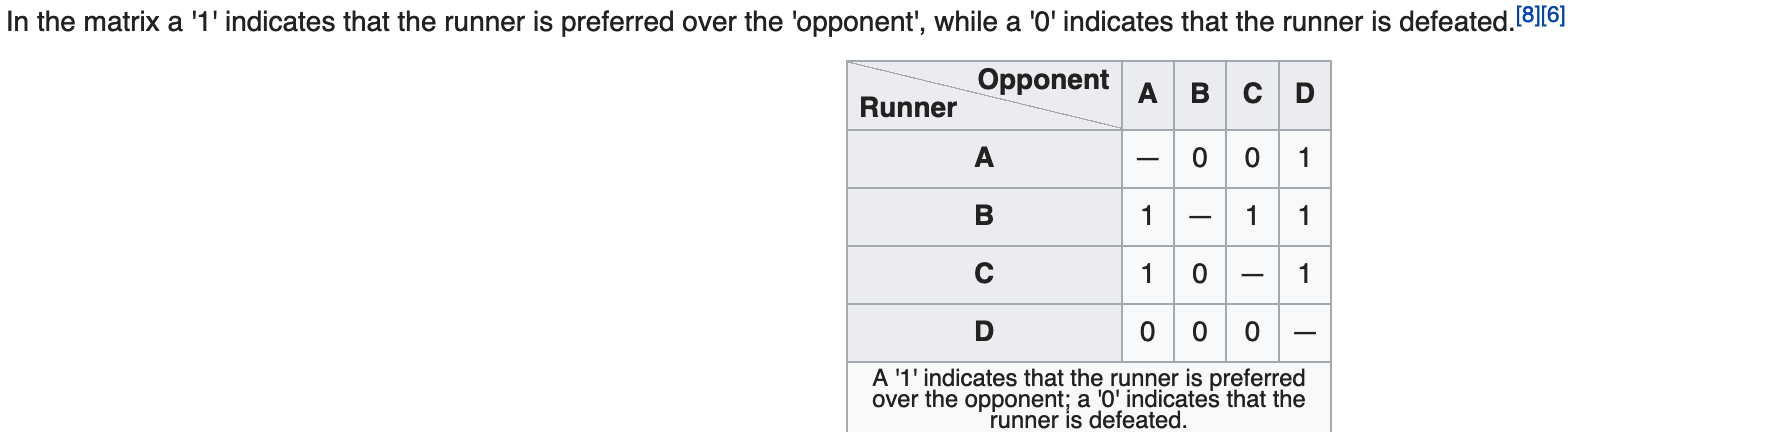

In [61]:
Image("Condorcet_wiki_table.png")

**As in the matrix above, in the symbolized matrix, `++` means runner won against opponent, `--` indicates runner is defeated**

In [62]:
Condorcet_winner(df1, candidates)

Creating the ballot dictionary...
Creating the candidate matrix to store pairwise results...

candidate_names:  ['Joseph M. Maestas', 'Kate I. Noble', 'Alan Webber', 'Peter N. Ives', 'Ronald S. Trujillo']

Updating the candidate matrix with pairwise results...




Joseph M. Maestas  Kate I. Noble  Alan Webber  \
Joseph M. Maestas                   0           5010         4366   
Kate I. Noble                    7776              0         5618   
Alan Webber                      8420           7168            0   
Peter N. Ives                    5799           4405         3483   
Ronald S. Trujillo               5168           4452         4091   

                    Peter N. Ives  Ronald S. Trujillo  
Joseph M. Maestas            6987                7618  
Kate I. Noble                8381                8334  
Alan Webber                  9303                8695  
Peter N. Ives                   0                7244  
Ronald S. Trujillo           5542                   0


Symbolizing the candidate matrix with pairwise results...



Joseph M. Maestas Kate I. Noble Alan Webber Peter N. Ives  \
Joseph M. Maestas                  `            --          --            ++   
Kate I. Noble                     ++             `          --            ++   
Alan Webber                       ++            ++           `            ++   
Peter N. Ives                     --            --          --             `   
Ronald S. Trujillo                --            --          --            --   

                   Ronald S. Trujillo  
Joseph M. Maestas                  ++  
Kate I. Noble                      ++  
Alan Webber                        ++  
Peter N. Ives                      ++  
Ronald S. Trujillo                  `



Condorcet results: 
Rank 1. Alan Webber: [Rank, (Wins, losses] [1, (4, 0)]
Rank 2. Kate I. Noble: [Rank, (Wins, losses] [2, (3, 1)]
Rank 3. Joseph M. Maestas: [Rank, (Wins, losses] [3, (2, 2)]
Rank 4. Peter N. Ives: [Rank, (Wins, losses] [4, (1, 3)]
Rank 5. Ronald S. Trujillo: [Rank, (Wins, losses] [5, (0, 4)]


### 5. To debug Condorcet step by step

In [43]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))



In [44]:
all_ballots = list(df1['ballot_objects'].values)
print("Creating the ballot dictionary...")

ballot_dict=create_ballot_dict(df1)
print("Creating the candidate matrix to store pairwise results...")

candidate_names=[]
for cand in candidates:
    candidate_names.append(cand.name)
    
print("\ncandidate_names: ",candidate_names)
cand_matrix= pd.DataFrame(0, columns=candidate_names, index=candidate_names)
cand_matrix

Creating the ballot dictionary...
Creating the candidate matrix to store pairwise results...

candidate_names:  ['Joseph M. Maestas', 'Kate I. Noble', 'Alan Webber', 'Peter N. Ives', 'Ronald S. Trujillo']


Joseph M. Maestas  Kate I. Noble  Alan Webber  \
Joseph M. Maestas                   0              0            0   
Kate I. Noble                       0              0            0   
Alan Webber                         0              0            0   
Peter N. Ives                       0              0            0   
Ronald S. Trujillo                  0              0            0   

                    Peter N. Ives  Ronald S. Trujillo  
Joseph M. Maestas               0                   0  
Kate I. Noble                   0                   0  
Alan Webber                     0                   0  
Peter N. Ives                   0                   0  
Ronald S. Trujillo              0                   0

In [45]:
print("\nUpdating the candidate matrix with pairwise results...")
#for votes, ballot in take(2,ballot_dict.values()):
for votes, ballot in ballot_dict.values():
    ranked_candidates = [cand.name for cand in list(ballot.ranked_candidates)]
    process_cands=list(cand_matrix.columns)
    for i, current_cand in enumerate(ranked_candidates):
        process_cands.remove(current_cand)
        cand_matrix.loc[current_cand][process_cands]=cand_matrix.loc[current_cand][process_cands]+votes
print("\n")
cand_matrix




Updating the candidate matrix with pairwise results...




Joseph M. Maestas  Kate I. Noble  Alan Webber  \
Joseph M. Maestas                   0           5010         4366   
Kate I. Noble                    7776              0         5618   
Alan Webber                      8420           7168            0   
Peter N. Ives                    5799           4405         3483   
Ronald S. Trujillo               5168           4452         4091   

                    Peter N. Ives  Ronald S. Trujillo  
Joseph M. Maestas            6987                7618  
Kate I. Noble                8381                8334  
Alan Webber                  9303                8695  
Peter N. Ives                   0                7244  
Ronald S. Trujillo           5542                   0

#### In case you want to see the difference in pairwise counts

In [46]:
cand_matrix1 = cand_matrix.copy(deep=True)
for i in cand_matrix1.columns:
    for j in cand_matrix1.index:
        cand_matrix1[i][j] = cand_matrix[i][j] - cand_matrix[j][i]
cand_matrix1

Joseph M. Maestas  Kate I. Noble  Alan Webber  \
Joseph M. Maestas                   0          -2766        -4054   
Kate I. Noble                    2766              0        -1550   
Alan Webber                      4054           1550            0   
Peter N. Ives                   -1188          -3976        -5820   
Ronald S. Trujillo              -2450          -3882        -4604   

                    Peter N. Ives  Ronald S. Trujillo  
Joseph M. Maestas            1188                2450  
Kate I. Noble                3976                3882  
Alan Webber                  5820                4604  
Peter N. Ives                   0                1702  
Ronald S. Trujillo          -1702                   0

### Simplify the matrix


In [47]:
for i in cand_matrix.index:
    for j in cand_matrix.columns:
        if i ==j:
            cand_matrix.loc[i,j] ='`'
        else:
            if cand_matrix.loc[i,j]!= '++' and cand_matrix.loc[i,j]!= '--':
                #print(i,j)
                #print("cand_matrix.loc[i,j]: ", cand_matrix.loc[i,j])
                #print("cand_matrix.loc[j,i]: ", cand_matrix.loc[j,i])
                if cand_matrix.loc[i,j]>cand_matrix.loc[j,i]:
                    #print('true')
                    cand_matrix.loc[i,j] = '++'
                    cand_matrix.loc[j,i] = '--'
                else:
                    #print('false')
                    cand_matrix.loc[i,j] = '--'
                    cand_matrix.loc[j,i] = '++'
display(cand_matrix)
#.loc(index, col)



Joseph M. Maestas Kate I. Noble Alan Webber Peter N. Ives  \
Joseph M. Maestas                  `            --          --            ++   
Kate I. Noble                     ++             `          --            ++   
Alan Webber                       ++            ++           `            ++   
Peter N. Ives                     --            --          --             `   
Ronald S. Trujillo                --            --          --            --   

                   Ronald S. Trujillo  
Joseph M. Maestas                  ++  
Kate I. Noble                      ++  
Alan Webber                        ++  
Peter N. Ives                      ++  
Ronald S. Trujillo                  `

In [48]:

result_dict={}
for i in cand_matrix.index:
    #print(list(cand_matrix.loc[i]))
    #print('Rank',countX(list(cand_matrix.loc[i]),'--')+1,':', i)
    key = ''.join([str(countX(list(cand_matrix.loc[i]),'--')+1), ". ",i])
    #print(key)
    result_dict[key]= [countX(list(cand_matrix.loc[i]),'--')+1, (countX(list(cand_matrix.loc[i]),'++'), countX(list(cand_matrix.loc[i]),'--'))]
for key, item in sorted(result_dict.items(), key=lambda x: x[1]):
    print("Rank %s: [Rank, (Wins, losses] %s" % (key, item))


Rank 1. Alan Webber: [Rank, (Wins, losses] [1, (4, 0)]
Rank 2. Kate I. Noble: [Rank, (Wins, losses] [2, (3, 1)]
Rank 3. Joseph M. Maestas: [Rank, (Wins, losses] [3, (2, 2)]
Rank 4. Peter N. Ives: [Rank, (Wins, losses] [4, (1, 3)]
Rank 5. Ronald S. Trujillo: [Rank, (Wins, losses] [5, (0, 4)]


### 6. Extras:

## To check on http://condorcet.ericgorr.net/condorcetCompute.php, input the following cell's results

In [49]:
#for item in take(2,ballot_dict.values()):
for item in ballot_dict.values():
    #print(item)
    res_str = str(item[0]) + ":"
    #print(item[0],":",)
    #if len(item[1].ranked_candidates)>1:
    for cand in item[1].ranked_candidates:
        res_str = res_str + cand.name + '>' 
    #print("*", res_str, "*", sep='')
    res_str=res_str[:-1]
    print(res_str)
    

264:Kate I. Noble>Joseph M. Maestas>Alan Webber>Peter N. Ives>Ronald S. Trujillo
72:Kate I. Noble>Peter N. Ives>Alan Webber>Ronald S. Trujillo>Joseph M. Maestas
823:Alan Webber>Kate I. Noble>Peter N. Ives>Joseph M. Maestas>Ronald S. Trujillo
266:Alan Webber>Peter N. Ives>Joseph M. Maestas>Kate I. Noble>Ronald S. Trujillo
406:Alan Webber>Joseph M. Maestas>Kate I. Noble>Peter N. Ives>Ronald S. Trujillo
104:Ronald S. Trujillo>Peter N. Ives>Joseph M. Maestas>Alan Webber>Kate I. Noble
58:Alan Webber>Ronald S. Trujillo>Peter N. Ives>Kate I. Noble>Joseph M. Maestas
42:Joseph M. Maestas>Ronald S. Trujillo>Kate I. Noble>Peter N. Ives>Alan Webber
438:Kate I. Noble>Alan Webber>Joseph M. Maestas>Peter N. Ives>Ronald S. Trujillo
118:Ronald S. Trujillo>Peter N. Ives>Joseph M. Maestas>Kate I. Noble>Alan Webber
186:Ronald S. Trujillo>Joseph M. Maestas>Peter N. Ives>Alan Webber>Kate I. Noble
40:Joseph M. Maestas>Alan Webber>Ronald S. Trujillo>Peter N. Ives>Kate I. Noble
678:Alan Webber>Kate I. Noble>Jo

#### In case you want to remove a candidate from all ballots(all_ballots) and write results to file

In [50]:
f=open('vote_rm_Andy.txt','w')
f.write('* ')
f.write(' '.join(['"'+cand.replace(' ', '')+'"' for cand in candidate_names if cand!="Andy Montroll"]))
f.write('\n')
for ele in all_ballots:
    #print(ele.ranked_candidates)
    cands = ['"'+cand.name.replace(' ', '')+'"' for cand in ele.ranked_candidates if cand.name!="Andy Montroll"]
    print('*',cands,'*', sep ='')
    if len(cands) == 0:
        continue
    f.write(' '.join(cands))
    f.write('\n')
f.close()

*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"JosephM.Maesta

*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maesta

*['"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"RonaldS.Trujill

*['"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"',

*['"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"AlanWebber"']*
*['"KateI.Noble"', '"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"AlanWebber"', '

*['"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"KateI.Noble"', 

*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', 

*['"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', 

*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"Ron

*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"AlanWebber"']*
*['"KateI.Noble"', '"AlanWebber"', '"Jos

*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"Kat

*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"']*
*['"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"Jos

*['"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"Kat

*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"']*
*['"KateI.Noble"', '"AlanWebber"', '"Pet

*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"Ron

*['"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"']*
*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"Pet

*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"']*
*['"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"Pet

*['"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"']*
*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"']*
*['"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"Ro

*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"',

*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"',

*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"Kat

*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"Pet

*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"', '"KateI.Noble"']*
*['"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"Pet

*['"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"KateI.Noble"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"', '"KateI.Noble"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"RonaldS.Trujillo"', '"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"PeterN.Ives"']*
*['"AlanWebber"', '"KateI.Noble"', '"Pet

*['"KateI.Noble"', '"AlanWebber"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"PeterN.Ives"']*
*['"KateI.Noble"', '"RonaldS.Trujillo"', '"JosephM.Maestas"', '"AlanWebber"', '"PeterN.Ives"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"AlanWebber"']*
*['"JosephM.Maestas"', '"PeterN.Ives"', '"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"AlanWebber"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"JosephM.Maestas"', '"KateI.Noble"', '"AlanWebber"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"KateI.Noble"', '"PeterN.Ives"', '"AlanWebber"', '"RonaldS.Trujillo"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"JosephM.Maestas"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"Jos

*['"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"', '"AlanWebber"']*
*['"KateI.Noble"', '"AlanWebber"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"PeterN.Ives"', '"RonaldS.Trujillo"']*
*['"PeterN.Ives"', '"AlanWebber"', '"JosephM.Maestas"', '"KateI.Noble"', '"RonaldS.Trujillo"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"KateI.Noble"', '"PeterN.Ives"', '"JosephM.Maestas"', '"RonaldS.Trujillo"']*
*['"RonaldS.Trujillo"', '"AlanWebber"', '"PeterN.Ives"', '"JosephM.Maestas"', '"KateI.Noble"']*
*['"AlanWebber"', '"KateI.Noble"', '"RonaldS.Trujillo"', '"PeterN.Ives"', '"JosephM.Maestas"']*
*['"AlanWebber"', '"JosephM.Maestas"', '

#### Function to do the same as above

In [51]:
def rm_cand_from_all_ballots(all_ballots, cand_name):
    file_name = 'vote_rm_'+cand_name+'.txt'
    f=open(file_name,'w')
    f.write('* ')
    f.write(' '.join(['"'+cand.replace(' ', '')+'"' for cand in candidate_names if cand!=cand_name]))
    f.write('\n')
    for ele in all_ballots:
    #print(ele.ranked_candidates)
        cands = ['"'+cand.name.replace(' ', '')+'"' for cand in ele.ranked_candidates if cand.name!=cand_name]
        #print('*',cands,'*', sep ='')
        if len(cands) == 0:
            continue
        f.write(' '.join(cands))
        f.write('\n')
    print("Wrote results to file: ", file_name)
    print("First line in file will be all candidates that contested the election preceded with a star(*)")
    f.close()

In [53]:
rm_cand_from_all_ballots(all_ballots, "Alan Webber")

Wrote results to file:  vote_rm_Alan Webber.txt
First line in file will be all candidates that contested the election preceded with a star(*)


In [ ]:
#vote_rm_Dan.txt
#vote_rm_James.txt
#vote_rm_Andy.txt
#vote_rm_Kurt.txt